In [1]:
# import torch as T
# import torch.nn as nn
# import torch.nn.functional as F
# import motion_capture.model.convolution as conv

# from motion_capture.core.torchhelpers import positionalencoding1d

# def make_even(x: int) -> int:
#     return x if x % 2 == 0 else x + 1

# class AttentionBlock(nn.Module):
#     def __init__(self, input_dims: int, num_heads: int):
#         super().__init__()
        
#         self.multi_head_attention = nn.MultiheadAttention(embed_dim=input_dims, num_heads=num_heads, batch_first=True)
#         self.attention_norm_1 = nn.LayerNorm(input_dims)
#         self.attention_ff = nn.Sequential(nn.Linear(input_dims, input_dims), nn.SiLU())
#         self.attention_norm_2 = nn.LayerNorm(input_dims)
        
#     def forward(self, q, k, v):
#         z_hat, _ = self.multi_head_attention(query = q, key = k, value = v)
#         z_hat = self.attention_norm_1(z_hat + q)
#         y = self.attention_norm_2(self.attention_ff(z_hat) + z_hat)
#         return y

# class PyramidTransformer(nn.Module):
#     def __init__(self, input_dims: int, input_length: int, num_heads: int):
#         super().__init__()
        
#         self.attention_block = AttentionBlock(input_dims, num_heads)
#         self.positional_encoding = nn.Parameter(positionalencoding1d(make_even(input_length), make_even(input_dims))[:input_dims, :input_length], requires_grad=False)
        
#     def forward(self, feature_map, memory):
        
#         in_shape = feature_map.shape
        
#         v_hat = (feature_map * memory).flatten(2)
#         pos_enc = self.positional_encoding.expand(feature_map.shape[0], -1, -1)
#         feature_map = feature_map.flatten(2)
        
#         y = self.attention_block(
#             q = (feature_map + pos_enc).permute(0, 2, 1),
#             k = (v_hat + pos_enc).permute(0, 2, 1),
#             v = v_hat.permute(0, 2, 1)
#         )
        
#         return y.permute(0, 2, 1).reshape(in_shape)

# class LL_LM_Attention(nn.Module):
#     def __init__(self, input_dims: int, query_length: int, memory_length: int, num_heads: int):
#         super().__init__()
        
#         self.query_positional_encoding = nn.Parameter(positionalencoding1d(make_even(query_length), make_even(input_dims))[:input_dims, :query_length].T, requires_grad=False)
#         self.memory_positional_encoding = nn.Parameter(positionalencoding1d(make_even(memory_length), make_even(input_dims))[:input_dims, :memory_length].T, requires_grad=False)
        
#         self.ll_attention_block = AttentionBlock(input_dims, 1)
#         self.lm_attention_block = AttentionBlock(input_dims, 1)
        
#     def forward(self, queries, memory):
        
#         qk = queries + self.query_positional_encoding.expand(queries.shape[0], -1, -1)
        
#         queries = self.ll_attention_block(qk, qk, queries)
        
#         lm_q = queries + self.query_positional_encoding.expand(queries.shape[0], -1, -1)
#         lm_k = memory + self.memory_positional_encoding.expand(memory.shape[0], -1, -1)
        
#         queries = self.lm_attention_block(lm_q, lm_k, memory)
        
#         return queries


# class PyramidTransformerHead(nn.Module):
#     # based on: https://arxiv.org/pdf/2207.03917.pdf
#     def __init__(
#         self, 
#         input_dims: int,
#         input_length: int,
#         output_dims: int,
#         output_length: int,
#         num_heads: int
#         ):
#         super().__init__()
        
#         self.output_shape = (output_length, output_dims)
        
        
#         self.upsample_2 = nn.Sequential(
#             nn.UpsamplingBilinear2d(scale_factor=2),
#             nn.Conv2d(input_dims, input_dims // 2, 1, 1)
#         )
#         self.pyramid_transformer_2 = PyramidTransformer(input_dims // 2, input_length * 4, num_heads)
        
#         self.upsample_1 = nn.Sequential(
#             nn.UpsamplingBilinear2d(scale_factor=2),
#             nn.Conv2d(input_dims // 2, input_dims // 4, 1, 1)
#         )
#         self.pyramid_transformer_1 = PyramidTransformer(input_dims // 4, input_length * 16, num_heads)
        
        
#         self.memory_encoder_3 = nn.Sequential(conv.C2f(input_dims, output_dims, 1, shortcut=True), nn.Flatten(2))
#         self.memory_encoder_2 = nn.Sequential(conv.C2f(input_dims // 2, output_dims, 1, shortcut=True), nn.Flatten(2))
#         self.memory_encoder_1 = nn.Sequential(conv.C2f(input_dims // 4, output_dims, 1, shortcut=True), nn.Flatten(2))
        
#         self.ll_lm_attention_3 = LL_LM_Attention(output_dims, output_length, input_length, num_heads)
#         self.ll_lm_attention_2 = LL_LM_Attention(output_dims, output_length, input_length * 4, num_heads)
#         self.ll_lm_attention_1 = LL_LM_Attention(output_dims, output_length, input_length * 16, num_heads)
        
#         self.initial_predictor = nn.Sequential(
#             conv.SPPF(input_dims, input_dims),
#             conv.C2f(input_dims, input_dims, 2, shortcut=True),
#             conv.C2f(input_dims, output_dims * output_length, 2, shortcut=False),
#             nn.AdaptiveAvgPool2d(1),
#             nn.Flatten(1)
#         )
        
#     def forward(self, x):
        
#         z_1, z_2, z_3 = x
        
#         memory_3 = z_3
        
#         memory_2 = self.pyramid_transformer_2(
#             feature_map = z_2, 
#             memory = self.upsample_2(memory_3)
#         )
        
#         memory_1 = self.pyramid_transformer_1(
#             feature_map = z_1, 
#             memory = self.upsample_1(memory_2)
#         )
        
#         enc_mem_3 = self.memory_encoder_3(memory_3).permute(0, 2, 1)
#         enc_mem_2 = self.memory_encoder_2(memory_2).permute(0, 2, 1)
#         enc_mem_1 = self.memory_encoder_1(memory_1).permute(0, 2, 1)
        
        
#         pred_3 = self.initial_predictor(memory_3).reshape(-1, *self.output_shape)
#         pred_2 = self.ll_lm_attention_3(pred_3, enc_mem_3) + pred_3
#         pred_1 = self.ll_lm_attention_2(pred_2, enc_mem_2) + pred_2
#         pred_0 = self.ll_lm_attention_1(pred_1, enc_mem_1) + pred_1
        
#         return pred_3, pred_2, pred_1, pred_0
    
#     def compute_loss(self, y_pred, y, loss_fn = F.l1_loss):
#         # compute residual loss for each of the predictions
#         return [loss_fn(y_p, y) for y_p in y_pred]


In [4]:
from motion_capture.model.trainingmodules import BBoxTrainingModule
import torch as T

model = BBoxTrainingModule(
    backbone_name = "convnextv2_atto.fcmae_ft_in1k",
    head_kwargs = {
        "input_dims": 320,
        "input_length": 49,
        "output_dims": 4,
        "output_length": 5,
        "num_heads": 8
    },
    lr_scheduler_kwargs = {
        "T_max": 50,
        "eta_min": 1e-5
    },
    optimizer_kwargs = {
        "lr": 0.1,
        "momentum": 0.9
    }
)

import pytorch_lightning as pl
trainer = pl.Trainer(max_epochs=50, accelerator="cuda")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [5]:
from motion_capture.data.datamodules import DataModule
from motion_capture.data.datasets import WIDERFace

dm = DataModule(
    dataset = WIDERFace(
        path="//192.168.2.206/data/datasets/WIDER-Face",
        image_shape_WH=(224, 224),
        max_number_of_faces=5
    ),
    y_key="bboxes",
    batch_size=1,
    image_augmentation=None,
    train_val_split=[0.8, 0.2],
    num_workers=2
)
dm.setup("fit")

In [34]:
losses = [
    (T.rand(4), T.ones(4)),
    (T.rand(4), T.ones(4)),
    (T.rand(4), T.ones(4))
]

a, b = [*zip(*losses)]
T.stack(a).shape

torch.Size([3, 4])

: 

In [6]:
trainer.fit(model, train_dataloaders=dm.train_dataloader())

c:\Users\noone\Documents\programming\motion-capture\.venv\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                   | Params | Mode 
------------------------------------------------------------
0 | backbone | FeatureListNet         | 3.4 M  | eval 
1 | head     | PyramidTransformerHead | 6.5 M  | train
2 | iouloss  | IouLoss                | 0      | train
------------------------------------------------------------
9.8 M     Trainable params
98.3 K    Non-trainable params
9.9 M     Total params
39.540    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/8431 [00:00<?, ?it/s] x tensor([[[[0.9961, 0.9961, 1.0000,  ..., 0.9647, 0.9608, 0.9490],
          [0.9843, 0.9961, 1.0000,  ..., 0.9608, 0.9608, 0.9490],
          [0.9804, 0.9922, 1.0000,  ..., 0.9608, 0.9608, 0.9490],
          ...,
          [0.9922, 0.9922, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9922, 0.9882, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
          [0.9882, 0.9843, 0.9922,  ..., 0.9961, 0.9961, 0.9961]],

         [[0.9059, 0.9294, 0.9373,  ..., 0.9294, 0.9255, 0.9137],
          [0.8941, 0.9294, 0.9373,  ..., 0.9255, 0.9255, 0.9137],
          [0.8902, 0.9255, 0.9373,  ..., 0.9255, 0.9255, 0.9137],
          ...,
          [0.9216, 0.9294, 0.9137,  ..., 0.9922, 0.9922, 0.9922],
          [0.9137, 0.9255, 0.9255,  ..., 0.9922, 0.9922, 0.9922],
          [0.9098, 0.9176, 0.9176,  ..., 0.9922, 0.9922, 0.9922]],

         [[0.7059, 0.7333, 0.7451,  ..., 0.8941, 0.8902, 0.8784],
          [0.6980, 0.7294, 0.7451,  ..., 0.8902, 0.8902,

NameError: name 'exit' is not defined

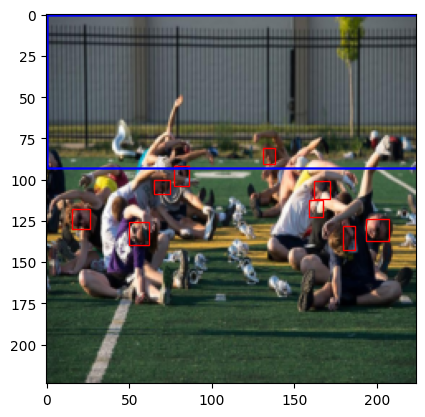

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


x, y = wider_face_dataset[2]


plt.imshow((x.permute(1, 2, 0) * 255).byte().numpy())

for bbox in y["bboxes"]:
    bbox = bbox * T.tensor([224] * 4)
    
    plt.gca().add_patch(
        Rectangle(
            (bbox[0], bbox[1]),
            bbox[2] - bbox[0], 
            bbox[3] - bbox[1], 
            linewidth=1,
            edgecolor="r", 
            facecolor="none"))

y_ = model(x.unsqueeze(0))[0]

for bbox in y_:
    bbox = bbox * T.tensor([224] * 4)
    bbox = bbox.detach()
    
    plt.gca().add_patch(
        Rectangle(
            (bbox[0], bbox[1]), 
            bbox[2] - bbox[0], 
            bbox[3] - bbox[1], 
            linewidth=1,
            edgecolor="b", 
            facecolor="none"))


In [1]:
import torch as T
from motion_capture.model.trainingmodules import find_best_checkpoint_path, BboxModule
from motion_capture.data.datasets import COCO2017GlobalPersonInstanceSegmentation, WIDERFace

wider_face_dataset = WIDERFace(
    path="//192.168.2.206/data/datasets/WIDER-Face",
    image_shape_WH=(224, 224),
    max_number_of_faces=5
)

model = BboxModule(
    backbone = "convnextv2_atto.fcmae_ft_in1k",
    head = {
        "input_dim": 320,
        "input_sequence_length": 49,
        
        "output_dim": 4,
        "output_sequence_length": 5,
        
        "depth": 1,
        "continuous_output": True,
    }
)

model.setup("training")

c:\Users\noone\Documents\programming\motion-capture\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
model.head.reverse1.conv1.conv.weight.sum()
model.head.att.out_proj.weight.sum()

tensor(-5.9372, grad_fn=<SumBackward0>)

In [4]:
# Example tensors
a = T.tensor([[[0.6725, 0.7745, 0., 0.],
               [0.4512, 0.8133, 0.2077, 0.5158],
               [0.3550, 0.4493, 0.2930, 0.8431],
               [0.3550, 0.4493, 0.2930, 0.8431],
               [0., 0., 0., 0.]]]) 
b = T.tensor([[[0.1191, 0.5191, 0.1289, 0.5355],
               [0.2402, 0.5164, 0.2520, 0.5355],
               [0.3550, 0.4493, 0.2930, 0.8431],
               [0.0000, 0.0000, 0.0000, 0.0000],
               [0.0000, 0.0000, 0.0000, 0.0000]]])

model.iouloss(a, b, ret_iou=True), model.compute_loss(a, b)

((tensor([[3.0000, 3.0000, 1.0000, 2.2171,    nan]]),
  tensor([[1., 1., 1., 1., nan]])),
 (tensor(1.), tensor(0.)))

In [5]:
device = "cuda"

model.backbone = model.backbone.eval()
model.heads = model.head.train()
model = model.to(device)

from torch.utils import data
x, y = data.DataLoader(wider_face_dataset, batch_size=10).__iter__().__next__()
x = x.to(device)
y = y["bboxes"].to(device)

opt = T.optim.AdamW(model.head.parameters(), lr=1e-4)

In [6]:
for i in range(100):
    
    y_pred = model(x)
    
    loss, liou = model.compute_loss(y_pred, y)
    if loss is None:
        break
    
    (loss + liou).backward()
    opt.step()
    opt.zero_grad()
    
    print(f"loss: {loss:2f}, IoU: {liou:2f}")

loss: 0.647932, IoU: 0.016486
loss: 0.357159, IoU: 0.019202
loss: 0.321639, IoU: 0.036982
loss: 0.260439, IoU: 0.069138
loss: 0.225290, IoU: 0.086999
loss: 0.216906, IoU: 0.087420
loss: 0.221308, IoU: 0.082906
loss: 0.236845, IoU: 0.080948
loss: 0.220265, IoU: 0.083520
loss: 0.213568, IoU: 0.086857
loss: 0.207328, IoU: 0.089474
loss: 0.142581, IoU: 0.090810
loss: 0.141906, IoU: 0.091309
loss: 0.139976, IoU: 0.091653
loss: 0.137633, IoU: 0.091985
loss: 0.134268, IoU: 0.092531
loss: 0.129817, IoU: 0.093324
loss: 0.124822, IoU: 0.094320
loss: 0.119653, IoU: 0.095789
loss: 0.114924, IoU: 0.097674
loss: 0.110486, IoU: 0.100059
loss: 0.106374, IoU: 0.102162
loss: 0.102609, IoU: 0.104199
loss: 0.099445, IoU: 0.106020
loss: 0.096858, IoU: 0.107526
loss: 0.094636, IoU: 0.108689
loss: 0.093029, IoU: 0.109286
loss: 0.092214, IoU: 0.109665
loss: 0.091476, IoU: 0.110163
loss: 0.090095, IoU: 0.110918
loss: 0.088252, IoU: 0.111908
loss: 0.086869, IoU: 0.112890
loss: 0.086025, IoU: 0.113456
loss: 0.08

tensor([[[8.4023e-09, 8.4025e-09, 8.1862e-09, 8.2000e-09],
         [8.4023e-09, 8.4025e-09, 8.1862e-09, 8.2000e-09],
         [8.4023e-09, 8.4025e-09, 8.1862e-09, 8.2000e-09],
         [8.4023e-09, 8.4025e-09, 8.1863e-09, 8.2000e-09],
         [8.4023e-09, 8.4025e-09, 8.1862e-09, 8.2000e-09]]],
       grad_fn=<SigmoidBackward0>)


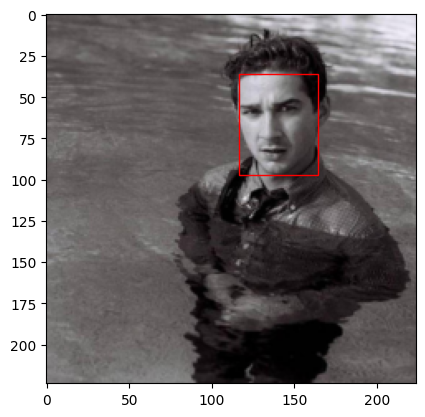

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

model = model.eval().to("cpu")

x, y = wider_face_dataset[4]

y_ = model(x.unsqueeze(0).to("cpu"))

plt.imshow((x.permute(1, 2, 0) * 255).byte().numpy())

for bbox in y["bboxes"]:
    bbox = bbox * T.tensor([224] * 4)
    
    plt.gca().add_patch(
        Rectangle(
            (bbox[0], bbox[1]),
            bbox[2] - bbox[0], 
            bbox[3] - bbox[1], 
            linewidth=1,
            edgecolor="r", 
            facecolor="none"))

print(y_)

for bbox in y_[0]:
    bbox = bbox * T.tensor([224] * 4)
    bbox = bbox.detach()
    
    plt.gca().add_patch(
        Rectangle(
            (bbox[0], bbox[1]), 
            bbox[2] - bbox[0], 
            bbox[3] - bbox[1], 
            linewidth=1,
            edgecolor="b", 
            facecolor="none"))

In [ ]:
# import timm
# import torch as T
# import torch.nn as nn
# import pytorch_lightning as pl
# from motion_capture.model.models import VQVAE, VQVAEHead

# class VisionModel(pl.LightningModule):
    
#     def __init__(
#         self,
        
#         backbone: str,
#         vqvae: dict,
#         heads: dict,
        
#         # - training parameters
#         optimizer: T.optim.Optimizer = None,
#         optimizer_kwargs: dict = None,
#         lr_scheduler_warmup_epochs: int = None,
#         lr_scheduler: T.optim.lr_scheduler = None,
#         lr_scheduler_kwargs: dict = None
        
#         # - loss scale parameters
#         reconstruction_loss_scale: float = 1.0,
#         codebook_loss_scale: float = 1.0,
#         prediction_loss_scales: dict = None
#         ):
        
#         super().__init__()
#         self.save_hyperparameters()
        
#         self.backbone = timm.create_model(backbone, pretrained=False, features_only=True)
#         self.vqvae = vqvae = VQVAE(**vqvae)
        
#         self.heads = nn.ModuleDict({k: VQVAEHead(**v) for k, v in heads.items()})
        
#     def forward(self, x, skip_backbone=False):
        
#         if not skip_backbone:
#             backbone_out = self.backbone(x)[-1].flatten(2).permute(0, 2, 1)
#         else:
#             backbone_out = x
        
#         vqvae_out = self.vqvae(backbone_out)
        
#         heads_out = {}
#         for k in self.heads:
#             heads_out[k] = self.heads[k](vqvae_out["codebook_onehots"])
        
#         return {
#             "heads": heads_out, 
#             "vqvae": vqvae_out
#         }
    
#     def get_losses(self, 
#         heads_out, heads_targets,
#         vqvae_out, vqvae_target):
        
#         reconstruction_loss, codebook_loss = self.vqvae.compute_loss(vqvae_reconstruction_target, vqvae_out["reconstruction"], vqvae_out["z"], vqvae_out["codebook_indecies"])
#         prediction_losses = {
#             k: self.hparams.prediction_loss_scales.get(k, 1) * self.heads[k].compute_loss(heads_targets[k], heads_out[k]) 
#             for k in self.heads
#         }
        
#         return {
#             "vqvae-reconstruction": reconstruction_loss * self.hparams.reconstruction_loss_scale,
#             "vqvae-codebook": codebook_loss * self.hparams.codebook_loss_scale,
#             **prediction_losses
#         }
    
#     # def head_wise_step(self, batch, mode):
        
#     #     x, y = batch
#     #     outputs = self(x)
#     #     losses = {}
#     #     for k, head_output in outputs.items():
#     #         loss = self.compute_loss(head_output, y[k], self.hparams.heads[k]["loss_fn"])
#     #         losses[k] = loss
#     #         self.log(f"{mode}_loss_{k}", loss, on_step=True, on_epoch=False, prog_bar=True)
#     #     self.log(f"{mode}_loss", sum(losses.values()) / len(losses), on_step=False, on_epoch=True, prog_bar=True)
#     #     return losses
    
#     # def training_step(self, batch, batch_id):
#     #     return self.head_wise_step(batch, "train")
#     # def validation_step(self, batch, batch_idx):
#     #     self.log("lr", self.trainer.optimizers[0].param_groups[0]["lr"], on_step=False, on_epoch=True, prog_bar=False)
#     #     return self.head_wise_step(batch, "val")
#     # def test_step(self, batch, batch_idx):
#     #     return self.head_wise_step(batch, "test")
    
#     # def configure_optimizers(self):
        
#     #     assert self.hparams.optimizer, "optimizer not set for training"
        
#     #     opt = self.hparams.optimizer(self.parameters(), **self.hparams.optimizer_kwargs)
        
#     #     warmup_scheduler = T.optim.lr_scheduler.LinearLR(opt, start_factor=0.1, total_iters=self.hparams.lr_scheduler_warmup_epochs)
#     #     scheduler = self.hparams.lr_scheduler(opt, **self.hparams.lr_scheduler_kwargs)
#     #     lr_scheduler = T.optim.lr_scheduler.SequentialLR(opt, schedulers=[
#     #         warmup_scheduler, 
#     #         scheduler
#     #     ], milestones=[self.hparams.lr_scheduler_warmup_epochs])
        
#     #     return {
#     #         "optimizer": opt,
#     #         "lr_scheduler": lr_scheduler
#     #     }

In [ ]:
# model = VisionModel(
#     backbone = "timm/convnextv2_atto.fcmae_ft_in1k",
#     vqvae = {
#         "input_dim": 320,
#         "codebook_dim": 512,
#         "num_codebook_entries": 1024,
#         "output_dim": 320,
#         "codebook_sequence_length": 15,
#         "output_sequence_length": 49,
#         "transformer": {
#             "nhead": 2,
#             "num_encoder_layers": 1,
#             "num_decoder_layers": 1,
#             "dim_feedforward": 512,
#             "dropout": 0.1,
#             "activation": "gelu"
#         }
#     },
#     heads = {
#         "personBbox": {
#             "input_dim": 1024,
#             "output_dim": 4,
#             "latent_dim": 512,
#             "output_sequence_length": 10,
#             "output_type": "continuous",
#             "transformer": {
#                 "nhead": 2,
#                 "num_encoder_layers": 1,
#                 "num_decoder_layers": 1,
#                 "dim_feedforward": 512,
#                 "activation": "gelu"
#             }
#         }
#     }
    
# )

## PyTorch Pretrained Models Speedtest

In [ ]:
from torchvision import models as torchModels
from motion_capture.model import models as mocapModels
import torch as T

In [ ]:
object_detection_models = {
    "fcos_resnet50_fpn": torchModels.detection.fcos_resnet50_fpn(weights=torchModels.detection.FCOS_ResNet50_FPN_Weights.COCO_V1),
    "fasterrcnn_mobilenet_v3_large_320_fpn": torchModels.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=torchModels.detection.FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1),
    "fasterrcnn_mobilenet_v3_large_fpn": torchModels.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=torchModels.detection.FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1),
    "fasterrcnn_resnet50_fpn_v2": torchModels.detection.fasterrcnn_resnet50_fpn_v2(weights=torchModels.detection.FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1),
    "fasterrcnn_resnet50_fpn": torchModels.detection.fasterrcnn_resnet50_fpn(weights=torchModels.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1),
    "retinanet_resnet50_fpn_v2": torchModels.detection.retinanet_resnet50_fpn_v2(weights=torchModels.detection.RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1),
    "retinanet_resnet50_fpn": torchModels.detection.retinanet_resnet50_fpn(weights=torchModels.detection.RetinaNet_ResNet50_FPN_Weights.COCO_V1),
    "ssd300_vgg16": torchModels.detection.ssd300_vgg16(weights=torchModels.detection.SSD300_VGG16_Weights.COCO_V1),
    "ssdlite320_mobilenet_v3_large": torchModels.detection.ssdlite320_mobilenet_v3_large(weights=torchModels.detection.SSDLite320_MobileNet_V3_Large_Weights.COCO_V1),
}